## Segmenting mother machine data with Omnipose

This notebook is adapted from the Omnipose docs' basic tutorial which can be found here: https://omnipose.readthedocs.io/examples/mono_channel_bact.html

Here we simply load a single TIFF stack of single mother machine trenches, and tile the images for more efficient segmentation.

In [1]:
import numpy as np
from cellpose import models, core
from cellpose import plot
import omnipose
from cellpose import models
from glob import glob
from natsort import natsorted

# This checks to see if you have set up your GPU properly.
# CPU performance is a lot slower, but not a problem if you 
# are only processing a few images.
use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

import tifffile
from skimage.transform import rescale, resize, downscale_local_mean

# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

2022-08-25 20:43:08,194 [INFO] ** TORCH CUDA version installed and working. **
>>> GPU activated? 1


Load in the first 8 frames of the timeseries data

In [2]:
real_data = tifffile.imread("real_data/trench_0.tif")[:8]
real_data = np.concatenate([data for data in real_data], axis=1)

Use omnipose's preprocessing step.

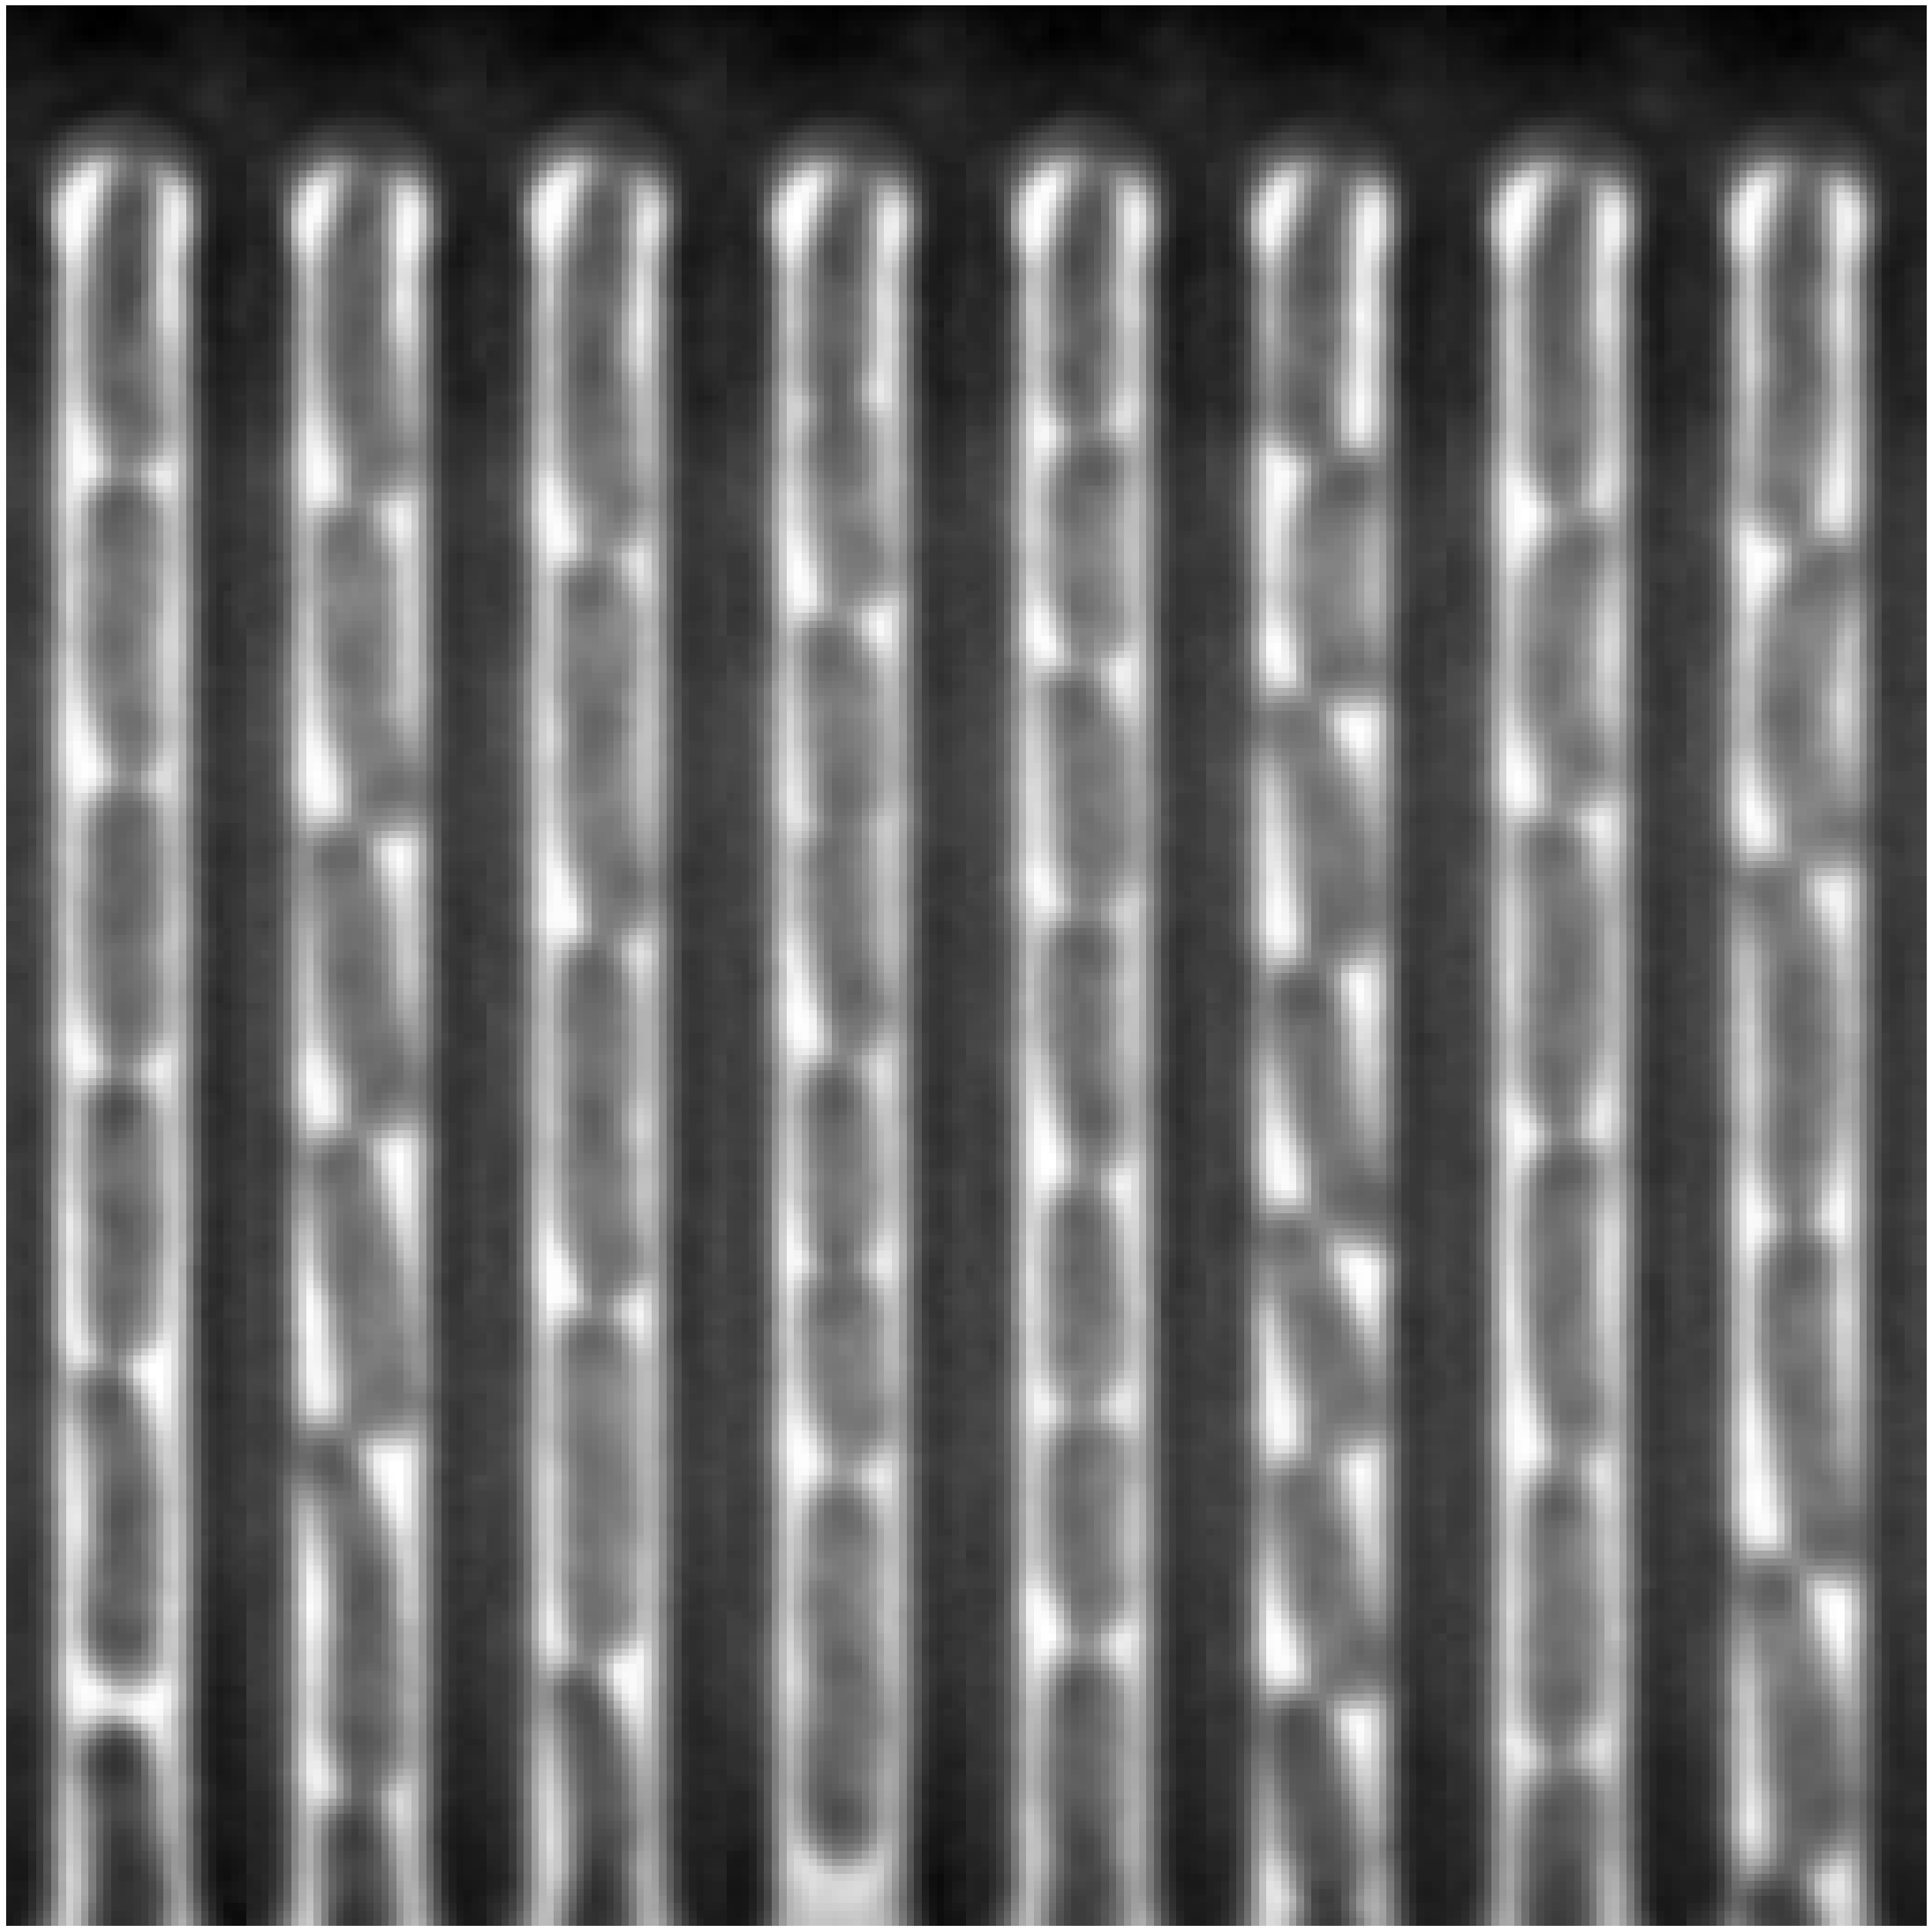

In [3]:
from cellpose import io, transforms
from omnipose.utils import normalize99
imgs = [real_data]
nimg = len(imgs)
fig = plt.figure(figsize=[40]*2) # initialize figure
for k in range(len(imgs)):
    img = transforms.move_min_dim(imgs[k]) # move the channel dimension last
    if len(img.shape)>2:
        imgs[k] = np.mean(img,axis=-1) # or just turn into grayscale 
        
    imgs[k] = normalize99(imgs[k])
    plt.subplot(1,len(imgs),k+1)
    plt.imshow(imgs[k],cmap='gray')
    plt.axis('off')

Load in the last model in the model directory in the training data directory.

In [4]:
model_list = natsorted(glob("omnipose_training_data_large/models/*"))
model_name = model_list[-1]
print(model_name)
use_gpu = use_GPU# = False
model = models.CellposeModel(gpu=use_gpu, pretrained_model=model_name, omni=True, concatenation=True)



omnipose_training_data_large/models/cellpose_residual_on_style_on_concatenation_off_omni_omnipose_training_data_large_2022_08_17_19_22_08.661299_epoch_3999
2022-08-25 20:43:08,897 [INFO] ** TORCH CUDA version installed and working. **
2022-08-25 20:43:08,897 [INFO] >>>> using GPU


Segment the image

In [5]:
chans = [0,0] #this means segment based on first channel, no second channel 

n = [0] # make a list of integers to select which images you want to segment
n = range(nimg) # or just segment them all 

# define parameters
mask_threshold = -1
verbose = 0 # turn on if you want to see more output 
use_gpu = use_GPU #defined above
transparency = True # transparency in flow output
rescale=None # give this a number if you need to upscale or downscale your images
omni = True # we can turn off Omnipose mask reconstruction, not advised 
flow_threshold = 0. # default is .4, but only needed if there are spurious masks to clean up; slows down output
resample = True #whether or not to run dynamics on rescaled grid or original grid 
masks, flows, styles = model.eval([imgs[i] for i in n],channels=chans,rescale=rescale,mask_threshold=mask_threshold,transparency=transparency,
                                  flow_threshold=flow_threshold,omni=omni,resample=resample,verbose=verbose)



Visualise the segmentation with omnipose's visualisation. 

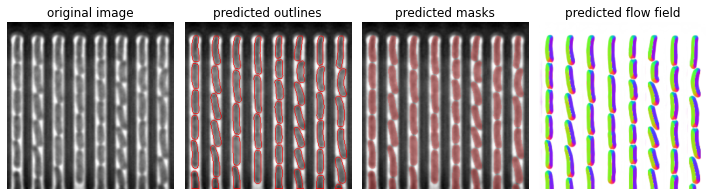

In [6]:
for idx,i in enumerate(n):

    maski = masks[idx]
    flowi = flows[idx][0]

    fig = plt.figure(figsize=(10,12))
    plot.show_segmentation(fig, omnipose.utils.normalize99(imgs[i]), maski, flowi, channels=chans, omni=True, bg_color=0)

    plt.tight_layout()
    plt.savefig(f"omnipose_diagnostics/{str(idx).zfill(4)}.png", dpi = 120)
    plt.show()